# Numerical tests of how sorting protocols change coincidences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyrepseq as prs
import pyrepseq.plotting as pp

plt.style.use('tcrspace.mplstyle')

In [2]:
nrepeats = 20
qsel = 1e-2
qneighsel = 0.1

In [3]:
df = pd.read_csv('data/minervina/beta/W_F1_2018_beta.txt.gz', sep='\t')
df.rename(columns={'aaSeqCDR3':'amino_acid'}, inplace=True)
df = df[df['amino_acid'].apply(prs.isvalidcdr3)]

In [4]:
back_norms, bins = prs.load_pcDelta_background()
hist_back_norm = back_norms['beta']

## Random cell selection

In [5]:
all_sequences_nt = df['amino_acid']
sampled_sequencess_nt = []
for i in range(nrepeats):
    sampled_sequences = all_sequences_nt[np.random.uniform(size=len(all_sequences_nt)) < 1-np.exp(-qsel*df['cloneCount'])]
    sampled_sequencess_nt.append(sampled_sequences)

## Random clonotype selection

In [6]:
all_sequences_aa = pd.unique(df['amino_acid'])
sampled_sequencess_uniform = []
for i in range(nrepeats):
    specific_sequences = all_sequences_aa[np.random.uniform(size=len(all_sequences_aa)) < qsel]
    sampled_sequences = np.array(df[df['amino_acid'].isin(specific_sequences)]['amino_acid'])
    sampled_sequencess_uniform.append(sampled_sequences)

## Random metaclonotype selection

In [7]:
local_densities = prs.calculate_neighbor_numbers(all_sequences_aa)

In [8]:
qstar = qneighsel
sampled_sequencess_neighbors_corrected = []
for i in range(nrepeats):
    specific_sequences = all_sequences_aa[np.random.rand(len(all_sequences_aa))<qsel/(1+qstar*local_densities)]
    specific_neighbors = []
    for seq in specific_sequences:
        for neighbor in prs.levenshtein_neighbors(seq):
            if np.random.rand() < qstar:
                specific_neighbors.append(neighbor)
    specific_all = list(specific_sequences)
    specific_all.extend(specific_neighbors)
    sampled_sequences = np.array(df[df['amino_acid'].isin(set(specific_all))]['amino_acid'])
    sampled_sequencess_neighbors_corrected.append(sampled_sequences)

## Plotting

In [9]:
def calc_stats(sequencess):
    ratios = []
    hists = []
    for i, sampled_sequences in enumerate(sequencess):
        hist_norm = prs.pcDelta(sampled_sequences, pseudocount=0.0, bins=bins)
        hists.append(hist_norm)
        ratio = (hist_norm / hist_back_norm)
        ratios.append(list(ratio))
    return hists, ratios

In [10]:
def ratio_plot(axes, hists, ratios):
    for i, hist in enumerate(hists):
        label = 'Samples' if i==0 else None
        axes[0].plot(bins[:-1], hist, '-', alpha=.25, color='k', label=label, zorder=0)
    for ratio in ratios:
        axes[1].plot(bins[:-1], ratio, '-', alpha=.25, color='k')
    hists = np.array(hists)
    l, = axes[0].plot(bins[:-1], hists.mean(axis=0), '-o', color='C1', label='Average', zorder=2)
    axes[0].plot(bins[:-1], hist_back_norm, '-o', color='C0', label='Background', zorder=1)
    axes[1].plot(bins[:-1], hists.mean(axis=0)/hist_back_norm, '-o', color=l.get_color())
    return np.array(ratios),hists

In [11]:
stats_nt = calc_stats(sampled_sequencess_nt)

In [12]:
stats_aa = calc_stats(sampled_sequencess_uniform)

In [13]:
stats_nn = calc_stats(sampled_sequencess_neighbors_corrected)

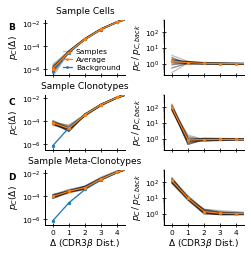

In [14]:
fig, axes = plt.subplots(figsize=(3.42, 3.5), ncols=2, nrows=3, sharex=True)

axes[0, 0].set_title('Sample Cells')
ratios, hists = ratio_plot(axes[0, :], *stats_nt)
axes[1, 0].set_title('Sample Clonotypes')
ratios, hists = ratio_plot(axes[1, :], *stats_aa)
axes[2, 0].set_title('Sample Meta-Clonotypes')
ratios, hists = ratio_plot(axes[2, :], *stats_nn)

axes[0, 0].legend(loc='lower right', fontsize='small')

for ax in axes[:, 0]:
    ax.set_ylabel(r'$p_C(\Delta)$')
for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(np.arange(5))
for ax in axes[:, 1]:
    ax.set_ylabel(r'$p_C\,/\,p_{C,back}$')
    ax.set_ylim(2e-1, 6e2)
for ax in axes[:, 0]:
    ax.set_yticks(10**-np.arange(2.0, 8.0, 2.0))
    ax.set_ylim(3e-7, 2e-2)
for ax in axes[-1, :]:
    ax.set_xlabel(r'$\Delta$ (CDR3$\beta$ Dist.)')
fig.tight_layout(pad=0.5)
pp.label_axes(axes[:, 0], labels='BCD', xy=(-0.45, 0.95))
fig.savefig('figures/raw/figure2BCD.svg')